In [1]:
import os
import sys
import shutil
os.environ['TOKENIZERS_PARALLELISM'] = "False"

import torch
import pandas as pd
import numpy as np
import decord
import json
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import PIL.Image
from glob import glob
from natsort import natsorted

from torch.utils.data import Dataset, DataLoader
from easydict import EasyDict as edict
import numpy as np
import json
import einops
from collections import defaultdict

import shared.utils as su
from utils.video import read_frames_decord
from utils.model import transform_pixel_values
from torchvision.transforms.v2 import (
    ToPILImage,
)
from models.modeling_encoders import AutoEncoder
from notebooks.eval_care_retrieval import load_model, load_data
from utils.video import read_frames_decord
from utils.model import transform_pixel_values
from torchvision.transforms.v2 import (
    ToPILImage,
    functional,
)

In [2]:
model_paths = {
    "Tarsier (Base Model)": "/work/piyush/pretrained_checkpoints/Tarsier-7b",
    "TARA (Ours)": "/work/piyush/pretrained_checkpoints/TARA",
}
device_map = "auto"
attn_implementation = 'flash_attention_2'

models = {}
for key, model_path in model_paths.items():
    model = AutoEncoder.from_pretrained(
        model_path,
        device_map=device_map,
        attn_implementation=attn_implementation,
        use_flash_attn=False,
        dtype=torch.bfloat16,
    )
    models[key] = model
    su.misc.num_params(model.model)
    print("-" * 100)
len(models)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading EncoderForTarsier from /work/piyush/pretrained_checkpoints/Tarsier-7b
### do_image_padding is set as False, images will be resized directly!


TarsierForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour


use_flash_attn is True and Flash Attention 2 is available on this GPU.
Using attn_implementation for TarsierForConditionalGeneration: flash_attention_2


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M
----------------------------------------------------------------------------------------------------
Loading EncoderForTarsier from /work/piyush/pretrained_checkpoints/TARA
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


use_flash_attn is True and Flash Attention 2 is available on this GPU.
Using attn_implementation for TarsierForConditionalGeneration: flash_attention_2


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M
----------------------------------------------------------------------------------------------------


2

In [72]:
df = pd.read_csv("./fold-unfold.csv")
# df = pd.read_csv("./fold-unfold-simple.csv")
df = df.iloc[:50]
del df['id']

embeds = {k: defaultdict(list) for k in models}
logits = {k: defaultdict(list) for k in models}

for col in df.columns:
    sentences = df[col].tolist()

    for key in models:
        model = models[key]
        for s in sentences:
            with torch.no_grad():
                # Text logits
                zt = model.encode_text(s)
                lt = model.model.language_model.lm_head(zt).cpu().float().squeeze(0)
            embeds[key][col].append(zt.cpu().float())
            logits[key][col].append(lt.cpu().float())
len(embeds), len(logits)

(2, 2)

In [73]:
embeds['TARA (Ours)'].keys()

dict_keys(['folding', 'unfolding', 'not_folding'])

### Project in separate spaces

In [85]:
z_base = torch.cat([torch.cat(embeds['Tarsier (Base Model)'][x]) for x in embeds['Tarsier (Base Model)']])
z_fine = torch.cat([torch.cat(embeds['TARA (Ours)'][x]) for x in embeds['TARA (Ours)']])

norm = lambda x: torch.nn.functional.normalize(x, dim=-1)
z_base = norm(z_base)
z_fine = norm(z_fine)

method = 'tsne'
p_base = su.visualize.reduce_dim(z_base, method=method)
p_fine = su.visualize.reduce_dim(z_fine, method=method)

z_base.shape, z_fine.shape

(torch.Size([150, 4096]), torch.Size([150, 4096]))

In [86]:
# n_samples = 50
n_samples = len(df)

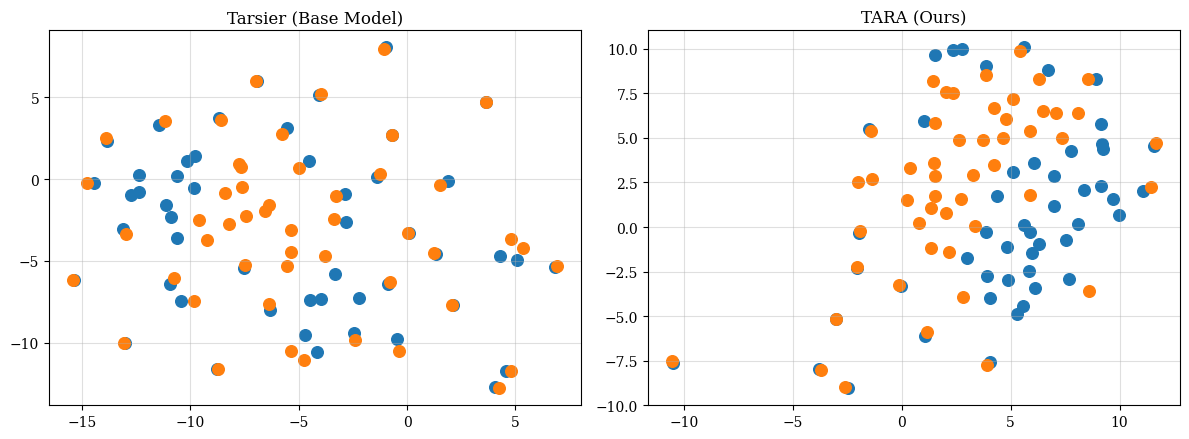

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

ax0 = axes[0]
ax0.grid(alpha=0.4)
ax0.set_title('Tarsier (Base Model)')

ax1 = axes[1]
ax1.grid(alpha=0.4)
ax1.set_title('TARA (Ours)')

L = ['folding', 'unfolding', 'not folding']
# C = ['blue', 'green', 'red']
C = ['tab:blue', 'tab:orange', 'red']
for j in range(2):
    idx_s = j * n_samples
    idx_e = (j + 1) * n_samples
    idx = np.arange(idx_s, idx_e)
    
    ax0.scatter(p_base[idx, 0], p_base[idx, 1], c=C[j], label=L[j], s=70)
    ax1.scatter(p_fine[idx, 0], p_fine[idx, 1], c=C[j], label=L[j], s=70)
# ax0.legend(fontsize=11)

# plt.scatter(p_base[:, 0], p_base[:, 1], c=colors)
plt.tight_layout()
# plt.savefig("../figures/fold-unfold-v1.pdf", bbox_inches='tight')
# plt.savefig("../figures/fold-unfold-notfold-v1.pdf", bbox_inches='tight')
plt.show()

In [88]:
def print_comparison(metrics1: dict, metrics2: dict, name1: str = "Model A", name2: str = "Model B"):
    col = max(len(name1), len(name2), 14)
    print(f"  {'Metric':<30} {name1:>{col}}  {name2:>{col}}")
    print("-" * (34 + col * 2))
    for key in metrics1:
        v1 = metrics1[key]
        v2 = metrics2.get(key, float('nan'))
        print(f"  {key:<30} {v1:>{col}.6f}  {v2:>{col}.6f}")

In [89]:
z_base_pos = z_base[0:n_samples]
z_base_neg = z_base[n_samples:2 * n_samples]

z_fine_pos = z_fine[0:n_samples]
z_fine_neg = z_fine[n_samples:2 * n_samples]

from shared.utils.embedding_distances import embedding_distance

metrics_base = embedding_distance(z_base_pos, z_base_neg)
metrics_fine = embedding_distance(z_fine_pos, z_fine_neg)

print_comparison(metrics_base, metrics_fine, "Base", "TARA")

  Metric                                   Base            TARA
--------------------------------------------------------------
  centroid_cosine_similarity           0.836506        0.524634
  centroid_euclidean_distance          0.408202        0.653177
  emd_euclidean                        0.677353        0.793539
  emd_cosine                           0.234981        0.320602
  mmd_rbf                              0.094988        0.087685
  kl_xy                             1679.647026     2207.229780
  kl_yx                             1900.899041     2565.251440
  js_divergence                     1790.273033     2386.240610
  frechet_distance                     0.453292        0.631958
  silhouette_euclidean                 0.066872        0.142922
  silhouette_cosine                    0.128307        0.263714
  calinski_harabasz                    8.323903       18.961055
  davies_bouldin                       3.417582        2.266030


### Joint projection

In [105]:
# Joint projection
n_base = len(z_base)
z = torch.cat([z_base, z_fine])
z = torch.nn.functional.normalize(z, dim=-1)

method = 'tsne'
p = su.visualize.reduce_dim(z, method=method)

p_base = p[:n_base]
p_fine = p[n_base:]

p_base.shape, p_fine.shape

((150, 2), (150, 2))

In [106]:
xmin, xmax = p[:, 0].min(), p[:, 0].max()
ymin, ymax = p[:, 1].min(), p[:, 1].max()

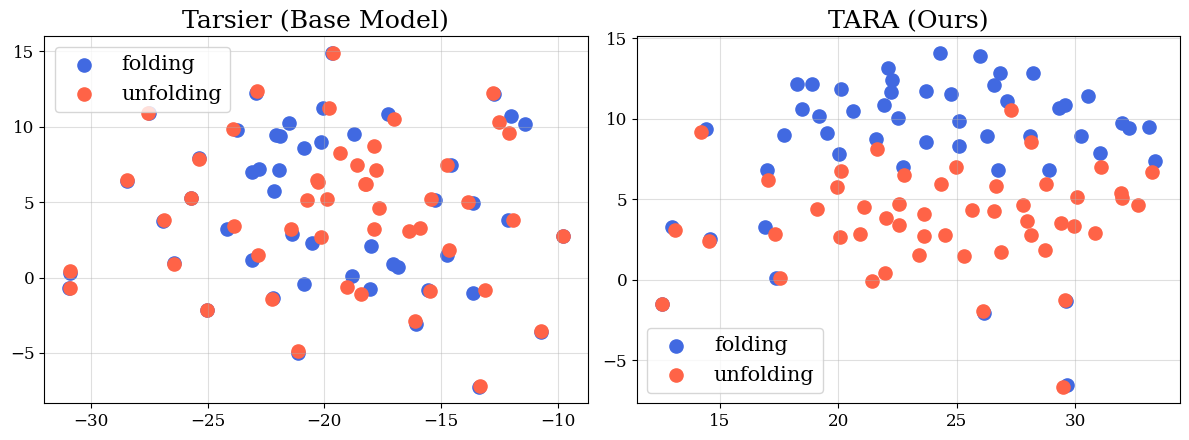

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

ax0 = axes[0]
ax0.grid(alpha=0.4)
ax0.set_title('Tarsier (Base Model)', fontsize=15)

ax1 = axes[1]
ax1.grid(alpha=0.4)
ax1.set_title('TARA (Ours)', fontsize=15)

L = ['folding', 'unfolding', 'not folding']
# C = ['blue', 'green', 'red']
# C = ['tab:blue', 'tab:orange', 'red']
C = ['royalblue', 'tomato', 'red']
for j in range(2):
    idx_s = j * n_samples
    idx_e = (j + 1) * n_samples
    idx = np.arange(idx_s, idx_e)

    s = 90
    ax0.scatter(p_base[idx, 0], p_base[idx, 1], c=C[j], label=L[j], s=s)
    ax1.scatter(p_fine[idx, 0], p_fine[idx, 1], c=C[j], label=L[j], s=s)
    
    ax0.legend(fontsize=15)
    ax1.legend(fontsize=15)
    su.visualize.increase_font_sizes(ax0, 1.1)
    su.visualize.increase_font_sizes(ax1, 1.1)

    # ax0.set_xlim(xmin, xmax)
    # ax0.set_ylim(ymin, ymax)

    
# ax0.legend(fontsize=11)

# plt.scatter(p_base[:, 0], p_base[:, 1], c=colors)
plt.tight_layout()
plt.savefig("../figures/fold-unfold-v2.pdf", bbox_inches='tight')
# plt.savefig("../figures/fold-unfold-notfold-v1.pdf", bbox_inches='tight')
plt.show()

In [93]:
z_base_pos = z[:n_base][0:n_samples]
z_base_neg = z[:n_base][n_samples:2 * n_samples]

z_fine_pos = z[n_base:][0:n_samples]
z_fine_neg = z[n_base:][n_samples:2 * n_samples]

z_base_pos.shape, z_base_neg.shape

(torch.Size([50, 4096]), torch.Size([50, 4096]))

In [94]:
metrics_base = embedding_distance(z_base_pos, z_base_neg)
metrics_fine = embedding_distance(z_fine_pos, z_fine_neg)

print_comparison(metrics_base, metrics_fine, "Base", "TARA")

  Metric                                   Base            TARA
--------------------------------------------------------------
  centroid_cosine_similarity           0.836506        0.524634
  centroid_euclidean_distance          0.408202        0.653176
  emd_euclidean                        0.677353        0.793539
  emd_cosine                           0.234981        0.320602
  mmd_rbf                              0.094987        0.087685
  kl_xy                             1679.645433     2207.227442
  kl_yx                             1900.897243     2565.249163
  js_divergence                     1790.271338     2386.238303
  frechet_distance                     0.453292        0.631957
  silhouette_euclidean                 0.066872        0.142922
  silhouette_cosine                    0.128307        0.263714
  calinski_harabasz                    8.323903       18.961055
  davies_bouldin                       3.417582        2.266030


### Modality gap (MSRVTT)

In [114]:
data_root = "/scratch/shared/beegfs/piyush/datasets/MSRVTT"
data = su.io.load_json(f"{data_root}/annotation/msrvtt_test_1k.json")
df = pd.DataFrame(data)
video_dir = f"{data_root}/videos/all/"

df['video_path'] = df.video.apply(lambda x: f"{video_dir}/{x}")
df['video_path'].apply(os.path.exists).mean()

1.0

In [117]:
def encode_vision_custom_prompt(encoder, pixel_values, prompt):

    pixel_values = transform_pixel_values(pixel_values) # [B, T, C, H, W]
    nframes = pixel_values.shape[1]

    to_image = ToPILImage()
    batched_frames = []
    for batch in pixel_values:
        frames = [to_image(v) for v in batch]
        batched_frames.append(frames)

    generate_kwargs = {
        "max_new_tokens": 1,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    }

    vision_embs = []

    for frames in batched_frames:
        input_prompt = prompt.replace("<video>", "<image>"*len(frames))
        input_ids = encoder.processor.get_text_inputs(input_prompt)
        frames = encoder.processor.get_pixel_values(frames)
        inputs = {
            "input_ids": input_ids,
            "pixel_values": frames
        }
        inputs = {k:v.to(encoder.model.device) for k,v in inputs.items() if v is not None}
        outputs = encoder.model.generate(
            **inputs,
            **generate_kwargs,
        )
        vision_embs.append(outputs.hidden_states[0][-1][:, -1, :])
    
    vision_embs = torch.cat(vision_embs)
    return vision_embs


def encode_text_custom_prompt(encoder, text, prompt):

    if isinstance(text, str):
        text = [text]
    
    prompts = [prompt.replace('<sent>', t) for t in text]

    generate_kwargs = {
        "max_new_tokens": 1,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    }

    text_embs = []

    for p in prompts:
        text_inputs = encoder.processor.get_text_inputs(p)
        inputs = {
            "input_ids": text_inputs,
        }
        inputs = {k:v.to(encoder.model.device) for k,v in inputs.items() if v is not None}
        outputs = encoder.model.generate(
            **inputs,
            **generate_kwargs,
        )
        text_embs.append(outputs.hidden_states[0][-1][:, -1, :])
    
    text_embs = torch.cat(text_embs)
    return text_embs


def postprocess_embed(z):
    return torch.nn.functional.normalize(z, dim=-1).cpu().float().squeeze(0)


def gather_embeddings(encoder, text_captions: list, video_paths: list, prompt_video: str, prompt_text: str):
    
    texts_embed = {}
    for text in su.log.tqdm_iterator(text_captions, desc='Computing text features'):
        with torch.no_grad():
            zt = encode_text_custom_prompt(encoder, text, prompt=prompt_text)
            zt = postprocess_embed(zt)
        texts_embed[text] = zt
    
    
    video_embed = {}
    for video_path in su.log.tqdm_iterator(video_paths, desc='Computing video features'):
        with torch.no_grad():
            video_tensor = read_frames_decord(video_path, 8).unsqueeze(0)
            zv = encode_vision_custom_prompt(encoder, video_tensor, prompt=prompt_video)
            zv = postprocess_embed(zv)
        video_embed[video_path] = zv
    
    return video_embed, texts_embed

In [118]:
captions = df.caption.tolist()
video_paths = df.video_path.tolist()
len(captions), len(video_paths)

(1000, 1000)

In [120]:
video_embeds = {}
texts_embeds = {}
for model_key in models:
    model = models[model_key]
    video_embed_eol, texts_embed_eol = gather_embeddings(
        encoder=model,
        text_captions=captions,
        video_paths=video_paths,
        prompt_video=model.video_eol_prompt,
        prompt_text=model.text_eol_prompt,
    )
    len(video_embed_eol), len(texts_embed_eol)
    video_embeds[model_key] = video_embed_eol
    texts_embeds[model_key] = texts_embed_eol
    print("-" * 100)

Computing text features:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing video features:   0%|          | 0/1000 [00:00<?, ?it/s]

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


----------------------------------------------------------------------------------------------------


Computing text features:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing video features:   0%|          | 0/1000 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------


In [126]:
save_dir = "/work/piyush/experiments/CaRe/embeddings"
os.makedirs(save_dir, exist_ok=True)
torch.save(video_embeds, f"{save_dir}/video_embeds-tarsier-tara-msrvtt.pt")
torch.save(texts_embeds, f"{save_dir}/texts_embeds-tarsier-tara-msrvtt.pt")

In [121]:
models.keys()

dict_keys(['Tarsier (Base Model)', 'TARA (Ours)'])

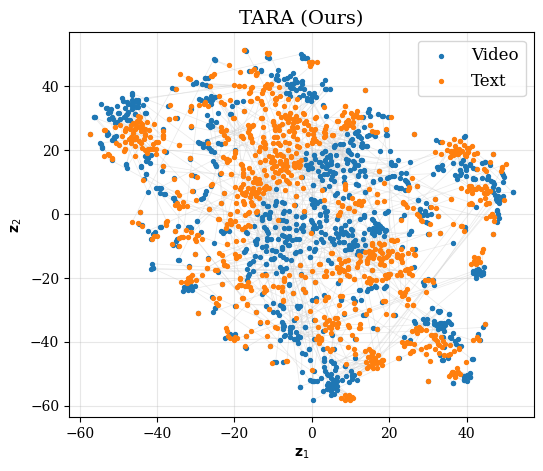

In [194]:
# key = 'Tarsier (Base Model)'
# save_path = "../figures/modality_gap-tasrier7b-msrvtt-v1.pdf"

key = 'TARA (Ours)'
save_path = "../figures/modality_gap-tara-msrvtt-v1.pdf"


# title_suffix = ""

_video_embeds = video_embeds[key]
_texts_embeds = texts_embeds[key]

# save_path = "../figures/tara+tarsier-msrvtt-no_eol.pdf"
# save_path = "../figures/tarsier-no_ego4d-msrvtt-no_eol.pdf"

# _video_embeds = video_embed_eol
# _texts_embeds = texts_embed_eol
# title_suffix = "With EOL prompt"
# # save_path = "../figures/tara+tarsier-msrvtt-with_eol.pdf"


target_col = 'caption'


ZV = torch.stack([_video_embeds[f] for f in _video_embeds])
ZT = torch.stack([_texts_embeds[t] for t in _texts_embeds])
Z = torch.concatenate([ZV, ZT], dim=0)
Z = norm(Z)
method = 'tsne'
# method = 'umap'
z = su.visualize.reduce_dim(Z, method=method)
Z.shape, z.shape

vid2text = {}
for f in _video_embeds:
    vid2text[f] = df[df.video_path == f].iloc[0][target_col]
len(vid2text)

# Create mappings from video/text to their index in z
video_list = list(_video_embeds.keys())
text_list = list(_texts_embeds.keys())

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# Draw matching lines first (so they appear behind the points)
for i, f in enumerate(video_list):
    matched_text = vid2text[f]
    if matched_text in text_list:
        j = text_list.index(matched_text)
        # Draw line from video point to text point
        ax.plot([z[i, 0], z[len(ZV) + j, 0]], 
                [z[i, 1], z[len(ZV) + j, 1]], 
                color='lightgray', linewidth=0.5, alpha=0.5, zorder=1)

# Draw scatter points on top
ax.scatter(z[:len(ZV), 0], z[:len(ZV), 1], s=8, label='Video', zorder=2)
ax.scatter(z[len(ZV):, 0], z[len(ZV):, 1], s=8, label='Text', zorder=2)

ax.grid(alpha=0.3)
ax.set_xlabel("$\\mathbf{z}_{1}$")
ax.set_ylabel("$\\mathbf{z}_{2}$")
ax.legend(fontsize=12)
# ax.set_title(f"2D tSNE projection ({title_suffix})", fontsize=14)
ax.set_title(key, fontsize=14)
# plt.savefig(save_path, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
y_label = kmeans.fit_predict(X)
silhouette_score(X, y_label)

In [156]:
key = 'Tarsier (Base Model)'
# key = 'TARA (Ours)'
_video_embeds = video_embeds[key]
_texts_embeds = texts_embeds[key]
ZV = torch.stack([_video_embeds[f] for f in _video_embeds])
ZT = torch.stack([_texts_embeds[t] for t in _texts_embeds])
Z = torch.concatenate([ZV, ZT], dim=0)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=2, random_state=42)
y_label = kmeans.fit_predict(Z)
silhouette_score(Z, y_label)

0.0619407594203949

In [157]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score

clf = LinearRegression()
y = np.array([1] * len(ZV) + [0] * len(ZT))
acc = cross_val_score(clf, Z, y, cv=5).mean()
print(acc)


0.19728080034255982


In [178]:
from sklearn.decomposition import PCA
import numpy as np

for key in models:
    print(key)
    _video_embeds = video_embeds[key]
    _texts_embeds = texts_embeds[key]
    ZV = torch.stack([_video_embeds[f] for f in _video_embeds])
    ZT = torch.stack([_texts_embeds[t] for t in _texts_embeds])
    Z = torch.concatenate([ZV, ZT], dim=0)
    pca = PCA()
    pca.fit(Z)
    
    print("Explained variance first 5 components:")
    print(pca.explained_variance_ratio_[:5])
    
    pc1 = pca.transform(Z)[:,0]
    print(np.corrcoef(pc1, y))
    print("-" * 80)
    # break


Tarsier (Base Model)
Explained variance first 5 components:
[0.06644643 0.01932987 0.01751599 0.01375797 0.01250421]
[[1.         0.97807671]
 [0.97807671 1.        ]]
--------------------------------------------------------------------------------
TARA (Ours)
Explained variance first 5 components:
[0.03424502 0.03314331 0.02974478 0.02722314 0.02054847]
[[1.         0.48212786]
 [0.48212786 1.        ]]
--------------------------------------------------------------------------------


In [179]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils import shuffle

clf = LogisticRegression(max_iter=5000, solver="saga")
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# real
scores_real = cross_val_score(clf, Z, y, cv=cv)
print("Real CV accuracy:", scores_real.mean())

# permutation test
n_perm = 5
perm_scores = []
rng = np.random.RandomState(0)
for i in range(n_perm):
    yperm = rng.permutation(y)
    s = cross_val_score(clf, Z, yperm, cv=cv).mean()
    perm_scores.append(s)

print("Perm mean:", np.mean(perm_scores), "std:", np.std(perm_scores))


Real CV accuracy: 1.0
Perm mean: 0.49854636591478696 std: 0.009370082362344209


In [182]:
np.linspace(1, 50, 8, dtype=int)

array([ 1,  8, 15, 22, 29, 36, 43, 50])

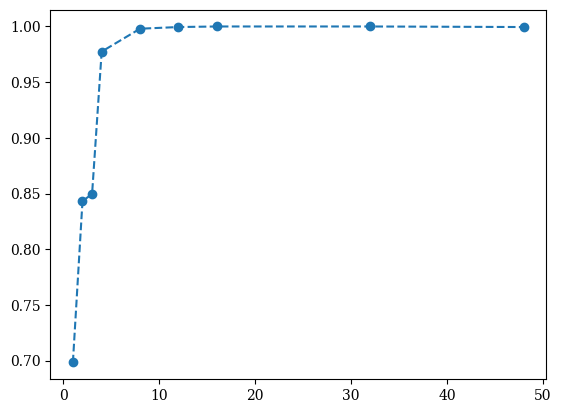

In [183]:
from sklearn.decomposition import PCA

K = [1, 2, 3, 4, 8, 12, 16, 32, 48]
A = []
for k in K:
    pca = PCA(n_components=k, random_state=0)
    X50 = pca.fit_transform(Z)
    
    scores_50 = cross_val_score(clf, X50, y, cv=cv)
    # print("CV accuracy (PCA 50):", scores_50.mean())
    A.append(scores_50.mean())

plt.plot(K, A, "--o")

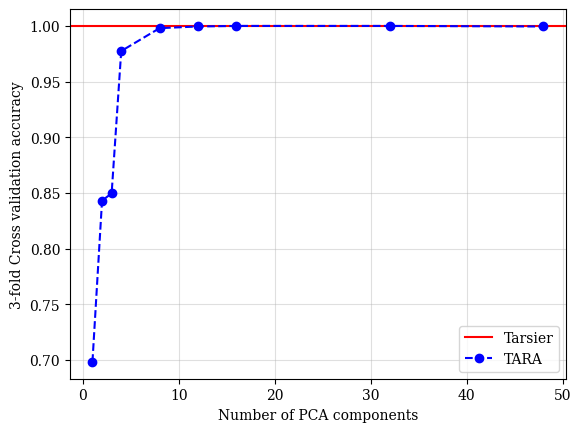

In [187]:
plt.axhline(y=1., color='red', label='Tarsier')
plt.plot(K, A, "--o", color='blue', label='TARA')
plt.grid(alpha=0.4)
plt.legend()
plt.ylabel("3-fold Cross validation accuracy")
plt.xlabel("Number of PCA components")
plt.show()

In [162]:
Z.shape

torch.Size([1995, 4096])

In [133]:
all_metrics = {}
for key in models:
    print(key)
    _video_embeds = video_embeds[key]
    _texts_embeds = texts_embeds[key]
    ZV = torch.stack([_video_embeds[f] for f in _video_embeds])
    ZT = torch.stack([_texts_embeds[t] for t in _texts_embeds])
    Z = torch.concatenate([ZV, ZT], dim=0)
    # Z_norm = norm(Z)
    Z_norm = Z
    ZV_norm = Z_norm[:len(ZV)]
    ZT_norm = Z_norm[len(ZV):]
    all_metrics[key] = embedding_distance(ZV_norm, ZT_norm)
all_metrics.keys()

Tarsier (Base Model)
TARA (Ours)


dict_keys(['Tarsier (Base Model)', 'TARA (Ours)'])

In [134]:
# Print measures
print_comparison(
    all_metrics['Tarsier (Base Model)'],
    all_metrics['TARA (Ours)'],
    "Base", "TARA",
)

  Metric                                   Base            TARA
--------------------------------------------------------------
  centroid_cosine_similarity           0.681638        0.644693
  centroid_euclidean_distance          0.436892        0.312582
  emd_euclidean                        1.137961        1.080023
  emd_cosine                           0.649178        0.588107
  mmd_rbf                              0.069234        0.065571
  kl_xy                             2157.113562     1635.730988
  kl_yx                             2261.398454     1608.383944
  js_divergence                     2209.256008     1622.057466
  frechet_distance                     0.643329        0.492430
  silhouette_euclidean                 0.061941        0.027209
  silhouette_cosine                    0.119028        0.052482
  calinski_harabasz                  135.772694       56.237720
  davies_bouldin                       3.828372        5.949764


In [131]:
all_metrics.keys()

dict_keys(['Tarsier (Base Model)', 'TARA (Ours)'])

0.0415
torch.Size([995000])
0.0723
torch.Size([995000])


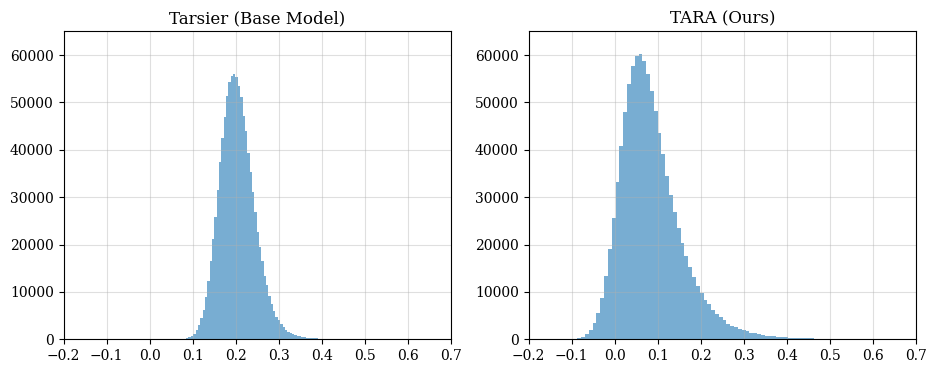

In [244]:
# key = 'Tarsier (Base Model)'
# key = 'TARA (Ours)'
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

i = 0
for key in models:
    _video_embeds = video_embeds[key]
    _texts_embeds = texts_embeds[key]
    ZV = torch.stack([_video_embeds[f] for f in _video_embeds])
    ZV = norm(ZV)
    # ZV_avg = ZV.mean(dim=0, keepdims=True)
    # ZV = ZV - ZV_avg
    ZT = torch.stack([_texts_embeds[t] for t in _texts_embeds])
    ZT = norm(ZT)
    # ZT_avg = ZT.mean(dim=0, keepdims=True)
    # ZT = ZT - ZT_avg
    Z = torch.concatenate([ZV, ZT], dim=0)
    sim = (ZV @ ZT.T).flatten()

    ax = axes[i]
    ax.hist(sim, bins=100, alpha=0.6);
    ax.set_title(key)
    ax.grid(alpha=0.4)

    rho = np.round(torch.std(sim).item(), 4)
    print(rho)
    ax.set_xlim(-0.2, 0.7)
    ax.set_ylim(0, 65000)
    i += 1
    
    print(sim.shape)

0.07225704193115234

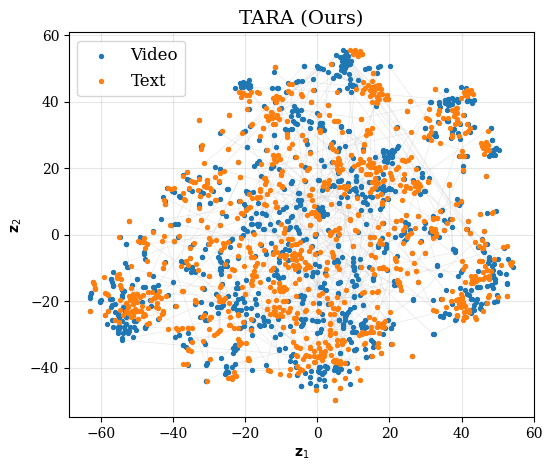

In [222]:
key = 'Tarsier (Base Model)'
key = 'TARA (Ours)'
_video_embeds = video_embeds[key]
_texts_embeds = texts_embeds[key]
ZV = torch.stack([_video_embeds[f] for f in _video_embeds])
ZV_avg = ZV.mean(dim=0, keepdims=True)
ZV = ZV - ZV_avg
ZT = torch.stack([_texts_embeds[t] for t in _texts_embeds])
ZT_avg = ZT.mean(dim=0, keepdims=True)
ZT = ZT - ZT_avg
Z = torch.concatenate([ZV, ZT], dim=0)

Z = norm(Z)
method = 'tsne'
# method = 'umap'
z = su.visualize.reduce_dim(Z, method=method)
Z.shape, z.shape

vid2text = {}
for f in _video_embeds:
    vid2text[f] = df[df.video_path == f].iloc[0][target_col]
len(vid2text)

# Create mappings from video/text to their index in z
video_list = list(_video_embeds.keys())
text_list = list(_texts_embeds.keys())

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# Draw matching lines first (so they appear behind the points)
for i, f in enumerate(video_list):
    matched_text = vid2text[f]
    if matched_text in text_list:
        j = text_list.index(matched_text)
        # Draw line from video point to text point
        ax.plot([z[i, 0], z[len(ZV) + j, 0]], 
                [z[i, 1], z[len(ZV) + j, 1]], 
                color='lightgray', linewidth=0.5, alpha=0.5, zorder=1)

# Draw scatter points on top
ax.scatter(z[:len(ZV), 0], z[:len(ZV), 1], s=8, label='Video', zorder=2)
ax.scatter(z[len(ZV):, 0], z[len(ZV):, 1], s=8, label='Text', zorder=2)

ax.grid(alpha=0.3)
ax.set_xlabel("$\\mathbf{z}_{1}$")
ax.set_ylabel("$\\mathbf{z}_{2}$")
ax.legend(fontsize=12)
# ax.set_title(f"2D tSNE projection ({title_suffix})", fontsize=14)
ax.set_title(key, fontsize=14)
# plt.savefig(save_path, bbox_inches='tight')
plt.show()

In [223]:
sim = norm(ZV) @ norm(ZT).T
sim.shape

torch.Size([1000, 995])

In [224]:
zt = torch.stack([_texts_embeds[x] for x in df.caption.tolist()])
zt.shape

torch.Size([1000, 4096])

In [226]:
c = []
for i in su.log.tqdm_iterator(range(len(df))):
    row = df.iloc[i].to_dict()
    zv = _video_embeds[row['video_path']]

    # Texts
    sim = zv @ zt.T
    # sim = (zv-ZV_avg[0]) @ (zt-ZT_avg[0]).T

    c.append(sim.argmax().item() in list(np.where(df.caption == row['caption'])[0]))
c = np.array(c)
np.mean(c)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.393

In [201]:
sim.argmax(dim=-1)

tensor([  0,   1,   2, 128,  74, 951, 757,  82,  12, 349, 563,  11, 442, 613,
         82, 256, 488, 255,  74, 148, 128, 626, 383,  23,  24, 125, 451,  74,
         28, 132,  30, 543,  32, 215,  34,  35,  28, 948,   1, 827, 449, 489,
         42,  23, 323, 454,  46,  47,  48,  49, 807, 828,  28, 869, 659,  55,
        735, 620,  58,  59, 304, 375, 951,  63, 318, 636,  66, 524,  68, 847,
        362, 125,  72, 586, 613,  75,  76,  28, 153, 622, 939, 378,  82, 153,
        855,  85,  86, 336, 336, 570, 378, 159, 349,  93, 215,  82, 754,  97,
         98, 112, 964, 101, 390, 817, 817, 869, 505, 375, 108, 109, 110, 543,
        112, 113,  74, 545, 866, 898, 118, 119, 451, 121, 964, 169, 543, 125,
          5, 127, 128, 129, 434, 600, 158, 479, 134, 269, 136, 137, 770, 963,
        651, 141, 542, 442, 879, 145, 869, 123, 148, 255, 359, 438, 337, 153,
        244, 377, 715, 678, 611, 435, 160, 867, 487, 153, 125, 165, 166, 153,
         88, 108, 835, 171, 849, 111, 302, 422, 722, 177, 178, 1

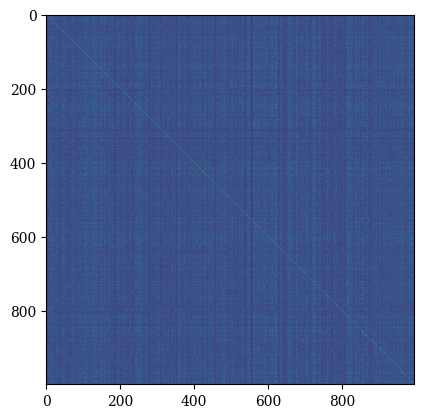

In [199]:
plt.imshow(sim)